In [4]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import *
from pyvenn import venn

# Benchmark of XIST-interacted proteins (Figure 2e,f)

## Load datasets

In [5]:
def load_annotation(path):
    anno = pd.read_csv(path, sep="\t")
    gene2entryies = defaultdict(list)
    entry2genes = defaultdict(list)
    for entry, genes in anno[anno["Reviewed"] == "reviewed"][["Entry",  "Gene Names"]].values:
        if isinstance(genes, str):
            for gene in genes.upper().split(" "):
                gene = gene.upper()
                gene2entryies[gene].append(entry)
                entry2genes[entry].append(gene)
        else:
            pass
            # print(entry)
    return anno, gene2entryies, entry2genes
    
anno_hg, gene2entries_hg, entry2genes_hg = load_annotation("../../common/uniprotkb/uniprotkb-245896766.human.tsv")
anno_mm, gene2entries_mm, entry2genes_mm = load_annotation("../../common/uniprotkb/uniprotkb-245896766.mouse.tsv")

In [6]:
data = dict()

In [7]:
# human entry (Protein ID)

for name in ["L1", "L3"]:
    d = pd.read_csv("results/Proteomic_XIST_%s.csv" % name, index_col=0)
    d = d[(d["Unique peptides R1"] >= 2) \
        & (d["Unique peptides R2"] >= 2) \
        & (d["Unique peptides R3"] >= 2) \
        & (~d["Ratio H/L normalized R1"].isna()) \
        & (~d["Ratio H/L normalized R2"].isna()) \
        & (~d["Ratio H/L normalized R3"].isna())].copy()
    d = d[(d["Log2FC"] > np.log2(1.5)) & (d["FDR"] < 0.05)]
    print(d.shape)
    data["TAPRIP_%s" % name] = set(d.index)

(90, 11)
(274, 11)


In [8]:
# human entry

for name in ["L1", "L3"]:
    d = pd.read_excel("data/BASU_XIST_interacting_proteins.xlsx", sheet_name="XIST-%s" % name)
    d = d[(d["logFC"] > np.log2(1.5)) & (d["P_enrich"] < 0.05)]
    entries = d["Accession"]
    print(len(entries), len(set(entries)))
    data["BASU_%s" % name] = set(entries)

28 28
38 38


In [9]:
# Converted to human entry before comparison.

def mouse_entry_to_human_entry(entries):
    entries2 = []
    for entry in entries:
        if entry in entry2genes_mm:
            tmp_entries = []
            for g in entry2genes_mm[entry]:
                if g in gene2entries_hg:
                    tmp_entries2 = gene2entries_hg[g]
                    tmp_entries.extend(tmp_entries2)
            tmp_entries = list(set(tmp_entries))
            if len(tmp_entries) == 0:
                entries2.append(entry)
            elif len(tmp_entries) == 1:
                entries2.append(tmp_entries[0])
            else:
                entries2.extend(tmp_entries)
        else:
            entries2.append(entry)
    return entries2

# mouse entry -> mouse genes -> human genes -> human entry

d = pd.read_excel("data/iDRiP_XIST_interacting_proteins.xlsx") # Mouse
entries = []
for x in d["Reference"]:
    for x2 in x.split(";"):
        entries.append(x2.split("|")[1])
entries = mouse_entry_to_human_entry(entries)
print(len(entries), len(set(entries)))
data["iDRiP"] = set(entries)

455 450


In [10]:
# mouse gene -> mouse entry -> mouse genes -> human genes -> human entry

d = pd.read_excel("data/CHIRMP-MS_XIST_interacting_proteins.xlsx") # gene name only, without protein accession
print(len(d))
entries = []
for g in d["Gene Symbol"]:
    g = g.upper()
    gs = [g]
    for e2 in gene2entries_mm[g]:
        for g2 in entry2genes_mm[e2]:
            gs.append(g2)
    gs = list(set(gs))

    entries2 = []
    for g2 in gs:
        entries2.extend(gene2entries_hg[g2])
    entries2 = list(set(entries2))
    # print(entries2)
    if len(entries2) == 0:
        entries.append(g)
    elif len(entries2) == 1:
        entries.append(entries2[0])
    else:
        entries.extend(entries2)
print(len(entries), len(set(entries)))
data["ChIRP_MS"] = set(entries)

81
93 91


## Venn4

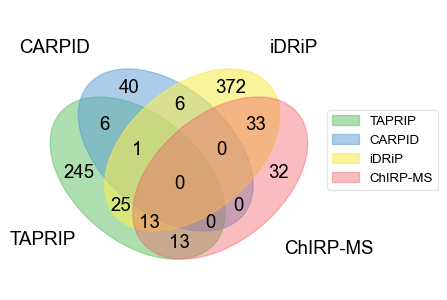

In [11]:
vs1 = data["TAPRIP_L1"] | data["TAPRIP_L3"]
vs2 = data["BASU_L1"] | data["BASU_L3"]
vs3 = data["iDRiP"]
vs4 = data["ChIRP_MS"]
array = [vs1, vs2, vs3, vs4]
array = [[v.upper() for v in vs] for vs in array]
labels = venn.get_labels(array, fill=['number', 'logic'])
for k, v in labels.items():
    labels[k] = v.split()[-1]
fig, ax = venn.venn4(labels, names=['TAPRIP', 'CARPID', 'iDRiP', 'ChIRP-MS'], figsize=(10, 3.8))
fig.savefig('figures/comparison_human_entry.venn4.pdf', bbox_inches='tight')

## Venn2

TAPRIP_L1 vs. TAPRIP_L3


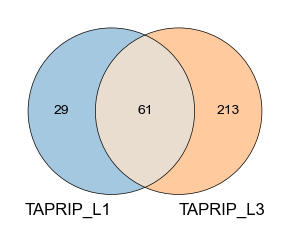

In [13]:
def plot_overlap(name1, name2):
    print("%s vs. %s" % (name1, name2))
    plt.figure(figsize=(3, 3))
    n1 = len(data[name1])
    n2 = len(data[name2])
    n3 = len(data[name1] & data[name2])
    # vs = [n1, n2, n3]
    vs = [1, 1, 1]
    res = venn2(vs, set_labels=[name1, name2], set_colors=["C0", "C1"])
    venn2_circles(vs, lw=0.5)
    res.subset_labels[0].set_text(str(n1 - n3))
    res.subset_labels[1].set_text(str(n2 - n3))
    if res.subset_labels[2]:
        res.subset_labels[2].set_text(str(n3))
    plt.tight_layout()
    # plt.show()
    plt.savefig("figures/comparison_human_entry.%s_vs_%s.venn2.pdf" % (name1, name2))
    plt.show()
    plt.close()

    # with open("comparison_by_genes_%s_vs_%s.csv" % (name1, name2), "w+") as fw:
    #     fw.write("Gene Names,Source,Type\n")
    #     for gs in hits1:
    #         fw.write(",".join(["|".join(gs), "Set1", "Overlap"]) + "\n")
    #     for gs in nohits1:
    #         fw.write(",".join(["|".join(gs), "Set1", "NotOverlap"]) + "\n")
    #     for gs in hits2:
    #         fw.write(",".join(["|".join(gs), "Set2", "Overlap"]) + "\n")
    #     for gs in nohits2:
    #         fw.write(",".join(["|".join(gs), "Set2", "NotOverlap"]) + "\n")

plot_overlap("TAPRIP_L1", "TAPRIP_L3")
# plot_overlap("TAPRIP_L1", "ChIRP_MS")
# plot_overlap("TAPRIP_L1", "iDRiP")
# plot_overlap("TAPRIP_L3", "ChIRP_MS")
# plot_overlap("TAPRIP_L3", "iDRiP")
# plot_overlap("BASU_L1", "ChIRP_MS")
# plot_overlap("BASU_L1", "iDRiP")
# plot_overlap("BASU_L3", "ChIRP_MS")
# plot_overlap("BASU_L3", "iDRiP")
# plot_overlap("BASU_L1", "BASU_L3")